# Pipeline de Análise de Mortalidade com Machine Learning

**Disciplina**: SCC0233 - Aplicações de Aprendizado de Máquina e Mineração de Dados

**Instituição**: ICMC - USP

---

## Objetivo

Este notebook implementa um pipeline completo de análise de dados de mortalidade, incluindo:

1. **Análise Exploratória de Dados (EDA)** - Compreensão dos padrões de mortalidade
2. **Clustering** - Agrupamento de municípios por perfil de mortalidade (ML não supervisionado)
3. **Regressão** - Previsão do número de óbitos futuros (ML supervisionado)
4. **Geração de Insights** - Interpretação para políticas públicas

---

## 1. Setup e Configuração

In [1]:
# Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# Configurações
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [3]:
# Variáveis de configuração global
CAMINHO_CSV = 'dataset/dataset.csv'
LIMIAR_MIN_OBITOS = 30  # Mínimo de óbitos por município-ano para incluir na análise
RANDOM_STATE = 42       # Seed para reprodutibilidade
K_MIN = 2               # Número mínimo de clusters a testar
K_MAX = 8               # Número máximo de clusters a testar

# Configurar seed global
np.random.seed(RANDOM_STATE)

---
## 2. Carregamento e Análise Exploratória de Dados (EDA)

In [4]:
# Carregamento do dataset
df_raw = pd.read_csv(CAMINHO_CSV, low_memory=False)

df_raw.head()

,Municipio,Ano,DTOBITO,CAUSABAS,CODMUNRES,IDADE,SEXO,RACACOR,ID,ESTCIV,ESC,OCUP
0,Rio Branco,2000,2000-01-19,I219,1200401,76.000,M,1.000,1,2.000,5,700.000
1,Rio Branco,2000,2000-01-19,E149,1200401,64.000,M,NaN,2,1.000,NaN,58200.000
2,Rio Branco,2000,2000-01-20,E142,1200401,61.000,M,2.000,3,2.000,1,700.000
3,Rio Branco,2000,2000-01-05,E146,1200401,76.000,M,4.000,4,2.000,9,700.000
4,Rio Branco,2000,2000-01-01,I219,1200401,75.000,F,4.000,5,1.000,NaN,700.000


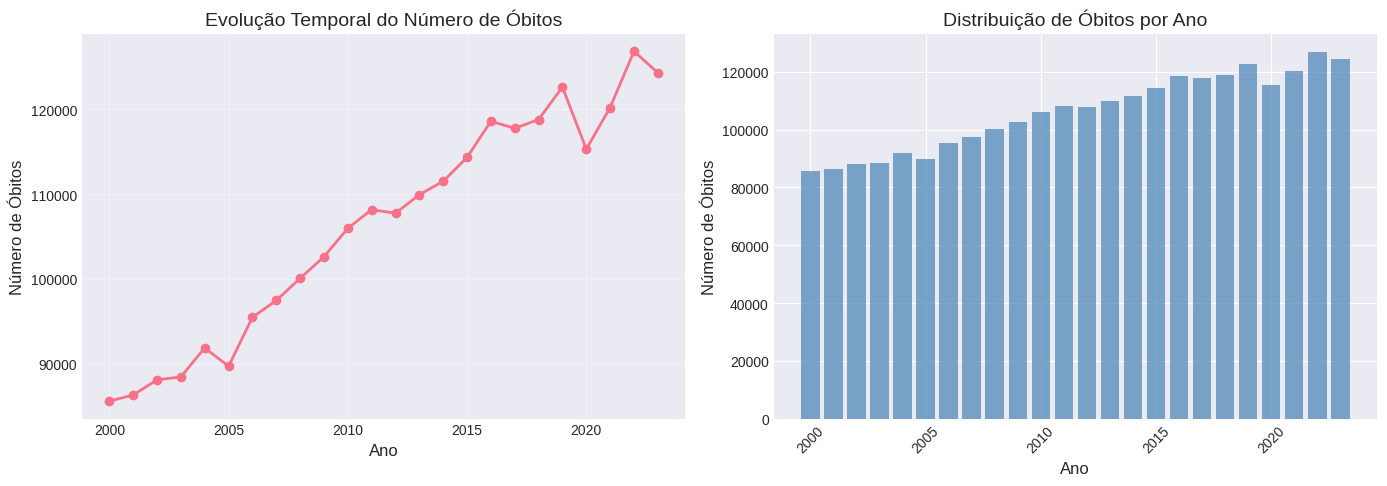

In [5]:
# Análise temporal - Distribuição por ano
dist_ano = df_raw['Ano'].value_counts().sort_index()
# Gráfico de série temporal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Série temporal
axes[0].plot(dist_ano.index, dist_ano.values, marker='o', linewidth=2, markersize=6)
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Número de Óbitos')
axes[0].set_title('Evolução Temporal do Número de Óbitos')
axes[0].grid(True, alpha=0.3)

# Barplot
axes[1].bar(dist_ano.index, dist_ano.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Número de Óbitos')
axes[1].set_title('Distribuição de Óbitos por Ano')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

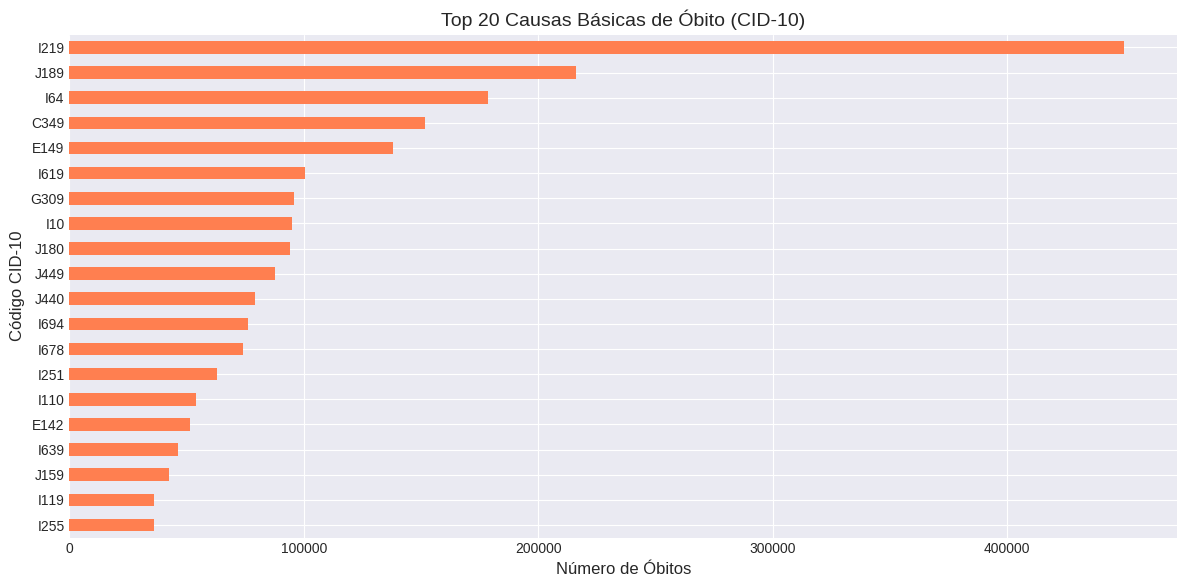


Distribuição por capítulo CID-10 (primeiro caractere):
capitulo_cid
C     155363
E     311546
G      98952
I    1407069
J     574647
Name: count, dtype: int64


In [6]:
# Análise de causas de morte (CID-10)

# Top 20 causas mais frequentes
top_causas = df_raw['CAUSABAS'].value_counts().head(20)

# Visualização das top causas
plt.figure(figsize=(12, 6))
top_causas.plot(kind='barh', color='coral')
plt.xlabel('Número de Óbitos')
plt.ylabel('Código CID-10')
plt.title('Top 20 Causas Básicas de Óbito (CID-10)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

# Análise de capítulos CID-10 (primeiro caractere)
df_raw['capitulo_cid'] = df_raw['CAUSABAS'].str[0]
dist_capitulos = df_raw['capitulo_cid'].value_counts().sort_index()
print(f"\nDistribuição por capítulo CID-10 (primeiro caractere):")
print(dist_capitulos)

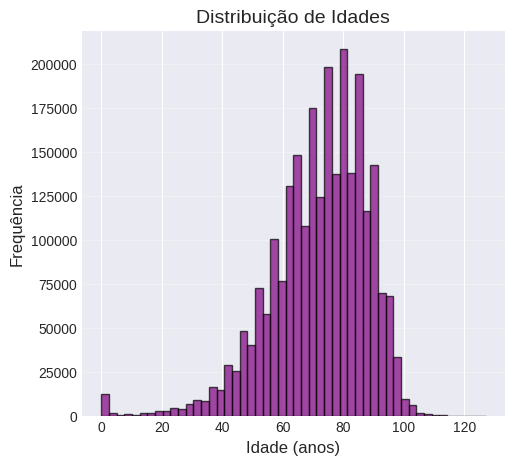

In [7]:
# Análise de idade

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df_raw['IDADE'].hist(bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.title('Distribuição de Idades')
plt.grid(axis='y', alpha=0.3)

plt.show()

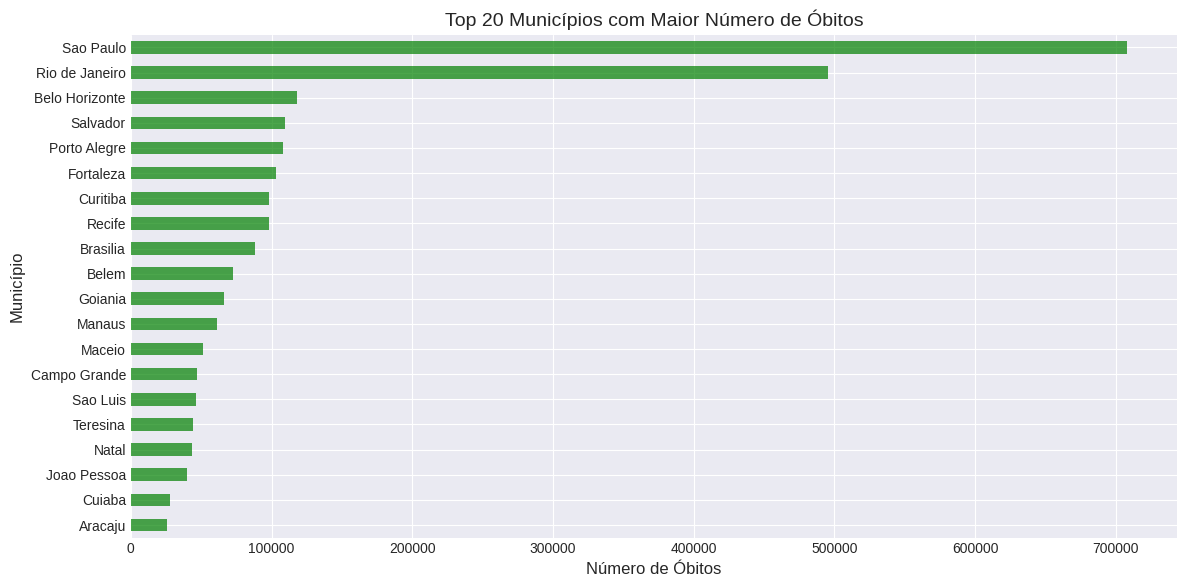

In [8]:
# Análise de municípios

# Top 20 municípios com mais óbitos
top_municipios = df_raw['Municipio'].value_counts().head(20)

# Visualização
plt.figure(figsize=(12, 6))
top_municipios.plot(kind='barh', color='green', alpha=0.7)
plt.xlabel('Número de Óbitos')
plt.ylabel('Município')
plt.title('Top 20 Municípios com Maior Número de Óbitos')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Limpeza e Transformação de Dados

In [9]:
# Criar cópia para manipulação
df = df_raw.copy()

print("=== LIMPEZA E TRANSFORMAÇÃO ===")
print(f"\nShape inicial: {df.shape}")

=== LIMPEZA E TRANSFORMAÇÃO ===

Shape inicial: (2547577, 13)


In [10]:
# 1. Converte a coluna DTOBITO de string/objeto para tipo datetime

# Converter para datetime (tratar possíveis erros)
df['DTOBITO'] = pd.to_datetime(df['DTOBITO'], errors='coerce')

# Criar colunas derivadas
df['ano_obito'] = df['DTOBITO'].dt.year
df['mes_obito'] = df['DTOBITO'].dt.month

In [11]:
# 2. Conversão de tipos - Código do município

# Garantir que CODMUNRES seja string (mantendo zeros à esquerda)
df['CODMUNRES'] = df['CODMUNRES'].astype(str).str.strip()

In [12]:
# 3. Conversão de idade para anos inteiros

df['idade_anos'] = pd.to_numeric(df['IDADE'], errors='coerce')

# Se houver idades muito altas (>120) ou formato especial, ajustar:
# Para simplificar, vamos manter a conversão direta e filtrar outliers

# Filtrar idades inválidas (menores que 0 ou maiores que 120)
df.loc[(df['idade_anos'] < 0) | (df['idade_anos'] > 120), 'idade_anos'] = np.nan

In [13]:
# 5. Criar grupos de causa (Feature Engineering)

def classificar_causa(cid):
    """
    Classifica a causa básica em grandes grupos segundo o capítulo CID-10.

    Mapeamento simplificado:
    - A, B: Infecciosas
    - C, D: Neoplasias
    - E: Endócrinas/Metabólicas
    - I: Circulatórias
    - J: Respiratórias
    - V, W, X, Y: Externas (acidentes, violência)
    - Outros: demais capítulos
    """
    if pd.isna(cid):
        return 'Outras'

    primeiro_char = str(cid)[0].upper()

    if primeiro_char in ['A', 'B']:
        return 'Infecciosas'
    elif primeiro_char in ['C', 'D']:
        return 'Neoplasias'
    elif primeiro_char == 'E':
        return 'Endócrinas'
    elif primeiro_char == 'I':
        return 'Circulatórias'
    elif primeiro_char == 'J':
        return 'Respiratórias'
    elif primeiro_char in ['V', 'W', 'X', 'Y']:
        return 'Externas'
    else:
        return 'Outras'

df['grupo_causa'] = df['CAUSABAS'].apply(classificar_causa)

print(f"\nDistribuição por grupo de causa:")
dist_grupo = df['grupo_causa'].value_counts()
print(dist_grupo)
print(f"\nProporções:")
print((100 * dist_grupo / dist_grupo.sum()).round(2))


Distribuição por grupo de causa:
grupo_causa
Circulatórias    1407069
Respiratórias     574647
Endócrinas        311546
Neoplasias        155363
Outras             98952
Name: count, dtype: int64

Proporções:
grupo_causa
Circulatórias   55.230
Respiratórias   22.560
Endócrinas      12.230
Neoplasias       6.100
Outras           3.880
Name: count, dtype: float64


In [14]:
# 6. Normalizar variável de sexo e criar variáveis binárias

# Garantir que sexo está em maiúsculo
df['SEXO'] = df['SEXO'].str.upper()

# Criar variável binária is_masculino
df['is_masculino'] = (df['SEXO'] == 'M').astype(int)

# Criar variável binária is_preta_parda para raça/cor
# Códigos 2 (Preta) e 4 (Parda)
df['is_preta_parda'] = df['RACACOR'].isin([2, 4]).astype(int)

---
## 4. Construção do Painel Município-Ano

In [15]:
# 1. Calcular total de óbitos por município-ano
painel = df.groupby(['CODMUNRES', 'ano_obito']).agg(
    obitos_total=('ID', 'count'),
    idade_media=('idade_anos', 'mean'),
    prop_masculino=('is_masculino', 'mean'),
    prop_preta_parda=('is_preta_parda', 'mean')
).reset_index()

print(painel.head(10))

  CODMUNRES  ano_obito  obitos_total  idade_media  prop_masculino  \
0    110020       2006           529       66.798           0.563   
1    110020       2007           499       66.199           0.523   
2    110020       2008           481       65.287           0.572   
3    110020       2009           527       64.772           0.607   
4    110020       2010           607       65.169           0.577   
5    110020       2011           643       67.748           0.541   
6    110020       2012           742       66.746           0.555   
7    110020       2013           664       68.454           0.554   
8    110020       2014           694       67.965           0.552   
9    110020       2015           658       69.508           0.547   

   prop_preta_parda  
0             0.588  
1             0.443  
2             0.489  
3             0.552  
4             0.606  
5             0.610  
6             0.625  
7             0.637  
8             0.627  
9             0.649 

In [16]:
# 2. Calcular número de óbitos por grupo de causa

# Pivot table para contar óbitos por grupo de causa
obitos_por_causa = df.groupby(['CODMUNRES', 'ano_obito', 'grupo_causa']).size().unstack(fill_value=0)
obitos_por_causa.columns = [f'obitos_{col.lower()}' for col in obitos_por_causa.columns]
obitos_por_causa = obitos_por_causa.reset_index()

print(obitos_por_causa.head())

  CODMUNRES  ano_obito  obitos_circulatórias  obitos_endócrinas  \
0    110020       2006                   299                 51   
1    110020       2007                   271                 82   
2    110020       2008                   227                140   
3    110020       2009                   281                 90   
4    110020       2010                   300                111   

   obitos_neoplasias  obitos_outras  obitos_respiratórias  
0                 39              1                   139  
1                 48              2                    96  
2                 40              1                    73  
3                 39              7                   110  
4                 53              2                   141  


In [17]:
# 3. Juntar com o painel principal
painel = painel.merge(obitos_por_causa, on=['CODMUNRES', 'ano_obito'], how='left')

# Preencher NaNs com 0 (se algum município-ano não tiver certa causa)
cols_causa = [col for col in painel.columns if col.startswith('obitos_')]
painel[cols_causa] = painel[cols_causa].fillna(0)

print(painel.head())

  CODMUNRES  ano_obito  obitos_total  idade_media  prop_masculino  \
0    110020       2006           529       66.798           0.563   
1    110020       2007           499       66.199           0.523   
2    110020       2008           481       65.287           0.572   
3    110020       2009           527       64.772           0.607   
4    110020       2010           607       65.169           0.577   

   prop_preta_parda  obitos_circulatórias  obitos_endócrinas  \
0             0.588                   299                 51   
1             0.443                   271                 82   
2             0.489                   227                140   
3             0.552                   281                 90   
4             0.606                   300                111   

   obitos_neoplasias  obitos_outras  obitos_respiratórias  
0                 39              1                   139  
1                 48              2                    96  
2                 40

In [18]:
# 4. Calcular proporções de cada grupo de causa - Cria novas colunas de proporção

# Identificar colunas de contagem de óbitos por causa
cols_obitos_causa = [col for col in painel.columns if col.startswith('obitos_') and col != 'obitos_total']

# Criar colunas de proporção
for col in cols_obitos_causa:
    nome_prop = col.replace('obitos_', 'prop_')
    # Evitar divisão por zero
    painel[nome_prop] = np.where(
        painel['obitos_total'] > 0,
        painel[col] / painel['obitos_total'],
        0
    )

cols_prop = [col for col in painel.columns if col.startswith('prop_')]
print(cols_prop)

['prop_masculino', 'prop_preta_parda', 'prop_circulatórias', 'prop_endócrinas', 'prop_neoplasias', 'prop_outras', 'prop_respiratórias']


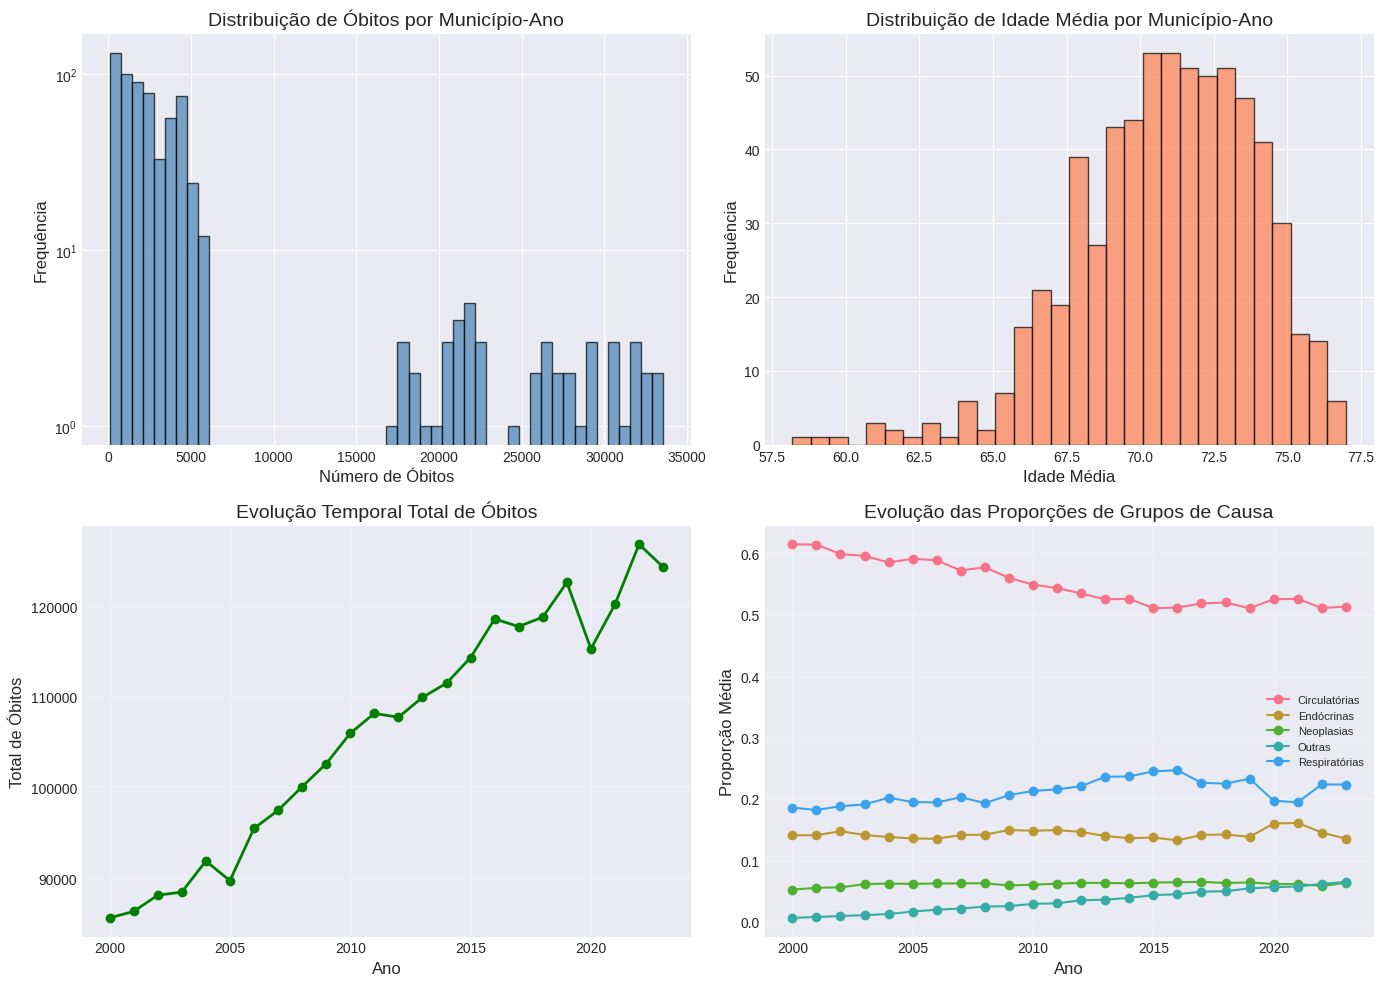

In [19]:
# 5. Visualizações do painel

# Cada barra conta quantos pares "município-ano" tiveram aquele número de óbitos.

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuição do total de óbitos
axes[0, 0].hist(painel['obitos_total'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Número de Óbitos')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].set_title('Distribuição de Óbitos por Município-Ano')
axes[0, 0].set_yscale('log')

# Distribuição de idade média
axes[0, 1].hist(painel['idade_media'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Idade Média')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição de Idade Média por Município-Ano')

# Evolução temporal do total de óbitos
obitos_por_ano = painel.groupby('ano_obito')['obitos_total'].sum()
axes[1, 0].plot(obitos_por_ano.index, obitos_por_ano.values, marker='o', linewidth=2, color='green')
axes[1, 0].set_xlabel('Ano')
axes[1, 0].set_ylabel('Total de Óbitos')
axes[1, 0].set_title('Evolução Temporal Total de Óbitos')
axes[1, 0].grid(True, alpha=0.3)

# Proporção média de grupos de causa ao longo do tempo
cols_prop_causa = [col for col in painel.columns if col.startswith('prop_') and
                   col not in ['prop_masculino', 'prop_preta_parda']]
prop_medias_ano = painel.groupby('ano_obito')[cols_prop_causa].mean()

for col in prop_medias_ano.columns:
    label = col.replace('prop_', '').title()
    axes[1, 1].plot(prop_medias_ano.index, prop_medias_ano[col], marker='o', label=label)

axes[1, 1].set_xlabel('Ano')
axes[1, 1].set_ylabel('Proporção Média')
axes[1, 1].set_title('Evolução das Proporções de Grupos de Causa')
axes[1, 1].legend(loc='best', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## 5. Clustering de Municípios por Perfil de Mortalidade

In [20]:
# 1. Preparar matriz de features para clustering

# Usar o ano mais recente disponível
ano_max = painel['ano_obito'].max()
print(f"Ano selecionado para clustering: {ano_max}")

# Filtrar dados do ano mais recente
df_clustering = painel[painel['ano_obito'] == ano_max].copy()
print(f"Municípios no ano {ano_max}: {len(df_clustering)}")

# Selecionar features para clustering
# Proporções de causas + características demográficas
feature_cols = [
    col for col in df_clustering.columns
    if col.startswith('prop_') and col != 'prop_preta_parda'  # Incluir todas proporções menos preta_parda se desejado
]
# Adicionar características demográficas
feature_cols.extend(['idade_media', 'prop_masculino', 'prop_preta_parda'])

print(f"\nFeatures selecionadas para clustering:")
print(feature_cols)

# Criar matriz X
X = df_clustering[feature_cols].copy()

# Remover linhas com NaN (se houver)
X = X.dropna()
df_clustering = df_clustering.loc[X.index]

print(f"\nShape da matriz de features: {X.shape}")
print(f"\nEstatísticas das features:")
print(X.describe())

Ano selecionado para clustering: 2023
Municípios no ano 2023: 27

Features selecionadas para clustering:
['prop_masculino', 'prop_circulatórias', 'prop_endócrinas', 'prop_neoplasias', 'prop_outras', 'prop_respiratórias', 'idade_media', 'prop_masculino', 'prop_preta_parda']

Shape da matriz de features: (27, 9)

Estatísticas das features:
       prop_masculino  prop_circulatórias  prop_endócrinas  prop_neoplasias  \
count          27.000              27.000           27.000           27.000   
mean            0.500               0.513            0.135            0.063   
std             0.040               0.036            0.037            0.017   
min             0.435               0.446            0.066            0.037   
25%             0.472               0.487            0.111            0.052   
50%             0.499               0.515            0.132            0.062   
75%             0.515               0.537            0.157            0.069   
max             0.598       

In [21]:
# 2. Padronizar features (z-score)...

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# 3. Testar diferentes valores de K

inercias = []
silhouettes = []
k_range = range(K_MIN, K_MAX + 1)

for k in k_range:
    print(f"  Testando K={k}...", end=' ')

    # Treinar K-Means
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Calcular métricas
    inercia = kmeans.inertia_

    # Silhouette (pode ser lento para muitos dados, usar amostra se necessário)
    if len(X_scaled) > 5000:
        # Usar amostra aleatória para cálculo de silhouette
        sample_idx = np.random.choice(len(X_scaled), 5000, replace=False)
        silhouette = silhouette_score(X_scaled[sample_idx], labels[sample_idx])
    else:
        silhouette = silhouette_score(X_scaled, labels)

    inercias.append(inercia)
    silhouettes.append(silhouette)

    print(f"Inércia: {inercia:.2f}, Silhouette: {silhouette:.3f}")

  Testando K=2... Inércia: 167.27, Silhouette: 0.230
  Testando K=3... Inércia: 125.73, Silhouette: 0.243
  Testando K=4... Inércia: 102.61, Silhouette: 0.211
  Testando K=5... Inércia: 91.41, Silhouette: 0.208
  Testando K=6... Inércia: 79.78, Silhouette: 0.200
  Testando K=7... Inércia: 72.29, Silhouette: 0.185
  Testando K=8... Inércia: 60.49, Silhouette: 0.199


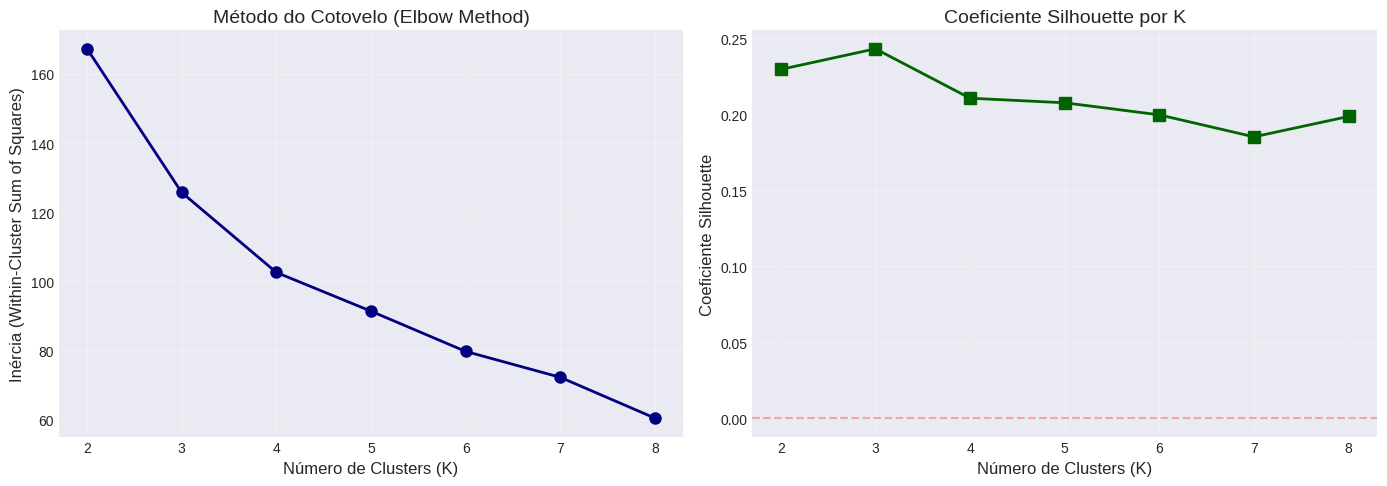

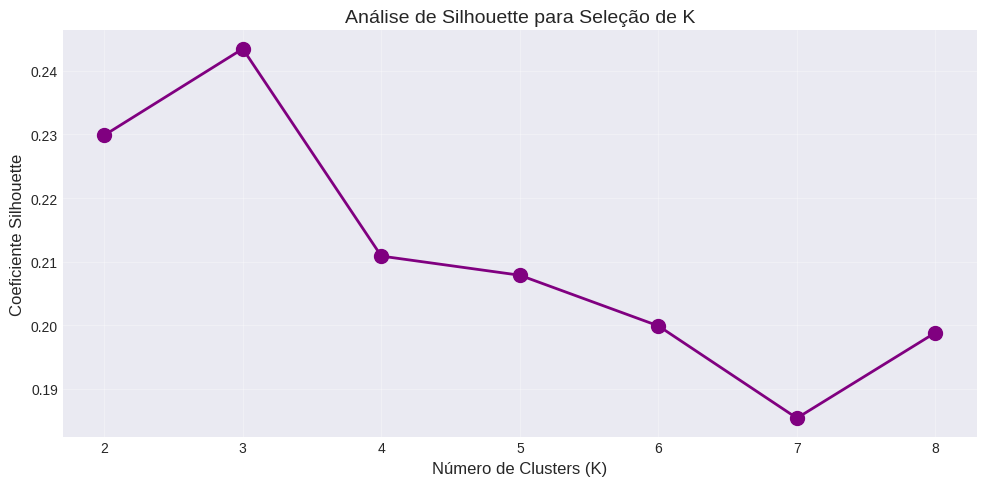

In [23]:
# 4. Visualizar métricas de avaliação

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de cotovelo (Elbow)
axes[0].plot(k_range, inercias, marker='o', linewidth=2, markersize=8, color='navy')
axes[0].set_xlabel('Número de Clusters (K)')
axes[0].set_ylabel('Inércia (Within-Cluster Sum of Squares)')
axes[0].set_title('Método do Cotovelo (Elbow Method)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Gráfico Silhouette
axes[1].plot(k_range, silhouettes, marker='s', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('Número de Clusters (K)')
axes[1].set_ylabel('Coeficiente Silhouette')
axes[1].set_title('Coeficiente Silhouette por K')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouettes, marker='o', linewidth=2, markersize=10, color='purple')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente Silhouette')
plt.title('Análise de Silhouette para Seleção de K')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

In [24]:
# 5. Escolher K ótimo

# Critério: maior silhouette (priorizando qualidade dos clusters)
k_otimo = k_range[np.argmax(silhouettes)]

In [25]:
# 6. Treinar modelo final com K ótimo

kmeans_final = KMeans(n_clusters=k_otimo, random_state=RANDOM_STATE, n_init=20)
df_clustering['cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"Distribuição de municípios por cluster:")
dist_clusters = df_clustering['cluster'].value_counts().sort_index()
print(dist_clusters)

print(f"\nProporção:")
print((100 * dist_clusters / dist_clusters.sum()).round(2))

Distribuição de municípios por cluster:
cluster
0     7
1     5
2    15
Name: count, dtype: int64

Proporção:
cluster
0   25.930
1   18.520
2   55.560
Name: count, dtype: float64


In [26]:
# 7. Interpretar clusters - Calcular perfil médio

# Calcular médias das features originais por cluster
perfil_clusters = df_clustering.groupby('cluster')[feature_cols].mean()

print(f"\nPerfil médio de cada cluster:")
print(perfil_clusters.round(3))


Perfil médio de cada cluster:
         prop_masculino  prop_circulatórias  prop_endócrinas  prop_neoplasias  \
cluster                                                                         
0                 0.552               0.499            0.147            0.059   
1                 0.467               0.500            0.147            0.088   
2                 0.487               0.525            0.126            0.057   

         prop_outras  prop_respiratórias  idade_media  prop_masculino  \
cluster                                                                 
0              0.041               0.254       70.033           0.552   
1              0.108               0.157       75.999           0.467   
2              0.061               0.231       73.618           0.487   

         prop_preta_parda  
cluster                    
0                   0.681  
1                   0.271  
2                   0.575  


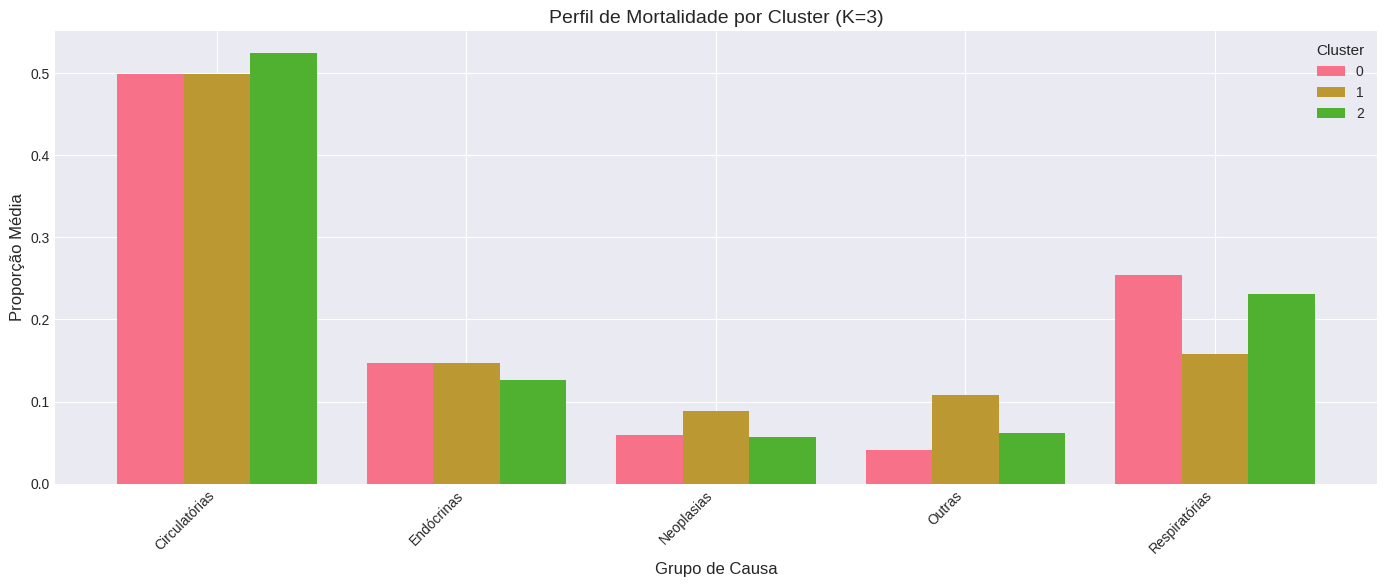

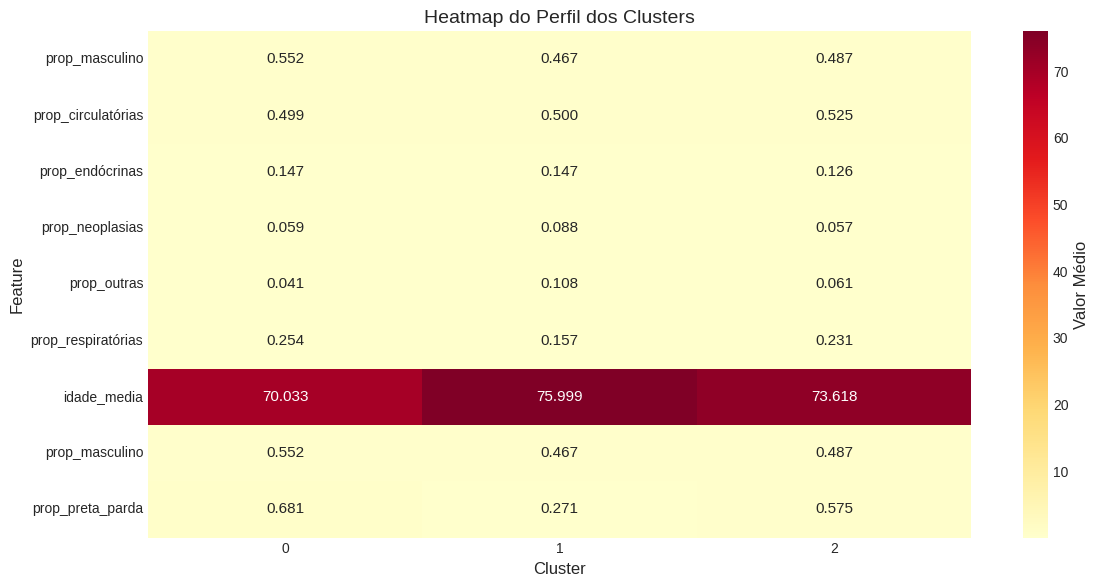

In [27]:
# 8. Visualizar perfil dos clusters

# Gráfico de barras comparando proporções de causas
cols_prop_causa_viz = [col for col in feature_cols if col.startswith('prop_') and
                       col not in ['prop_masculino', 'prop_preta_parda']]

perfil_viz = perfil_clusters[cols_prop_causa_viz]
perfil_viz.columns = [col.replace('prop_', '').title() for col in perfil_viz.columns]

ax = perfil_viz.T.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.xlabel('Grupo de Causa')
plt.ylabel('Proporção Média')
plt.title(f'Perfil de Mortalidade por Cluster (K={k_otimo})')
plt.legend(title='Cluster', loc='best')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Heatmap do perfil
plt.figure(figsize=(12, 6))
sns.heatmap(perfil_clusters.T, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Valor Médio'})
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.title('Heatmap do Perfil dos Clusters')
plt.tight_layout()
plt.show()

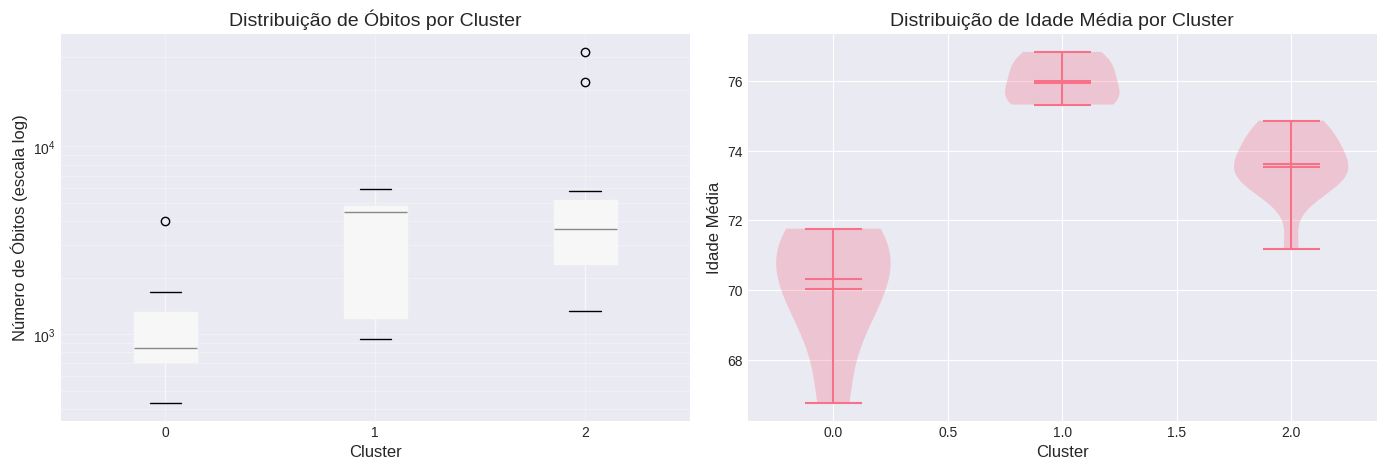

In [28]:
# 9. Análise de distribuição de óbitos por cluster

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot de óbitos por cluster com escala logarítmica
df_clustering.boxplot(column='obitos_total', by='cluster', ax=axes[0], patch_artist=True)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Número de Óbitos (escala log)')
axes[0].set_title('Distribuição de Óbitos por Cluster')
axes[0].set_yscale('log')  # Usar escala logarítmica para melhor visualização
axes[0].get_figure().suptitle('')  # Remover título automático
axes[0].grid(True, alpha=0.3, which='both')  # Melhorar grid para escala log

# Violin plot de idade média por cluster
from matplotlib import patches
parts = axes[1].violinplot(
    [df_clustering[df_clustering['cluster'] == c]['idade_media'].values for c in sorted(df_clustering['cluster'].unique())],
    positions=sorted(df_clustering['cluster'].unique()),
    showmeans=True,
    showmedians=True
)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Idade Média')
axes[1].set_title('Distribuição de Idade Média por Cluster')

plt.tight_layout()
plt.show()

### 6. Municípios por Cluster

Esta seção mostra **quais municípios específicos** foram atribuídos a cada cluster, permitindo identificar padrões geográficos e planejar intervenções direcionadas.

In [29]:
# 1. Obter nomes dos municípios do dataset original
# Criar mapeamento CODMUNRES -> Nome do Município
mapa_municipios = df[['CODMUNRES', 'Municipio']].drop_duplicates().set_index('CODMUNRES')['Municipio'].to_dict()

# Adicionar nome do município ao df_clustering
df_clustering['Municipio'] = df_clustering['CODMUNRES'].map(mapa_municipios)

# 2. Criar tabela detalhada de municípios por cluster
municipios_cluster = df_clustering[['Municipio', 'CODMUNRES', 'cluster', 'obitos_total', 'idade_media']].copy()
municipios_cluster = municipios_cluster.sort_values(['cluster', 'obitos_total'], ascending=[True, False])

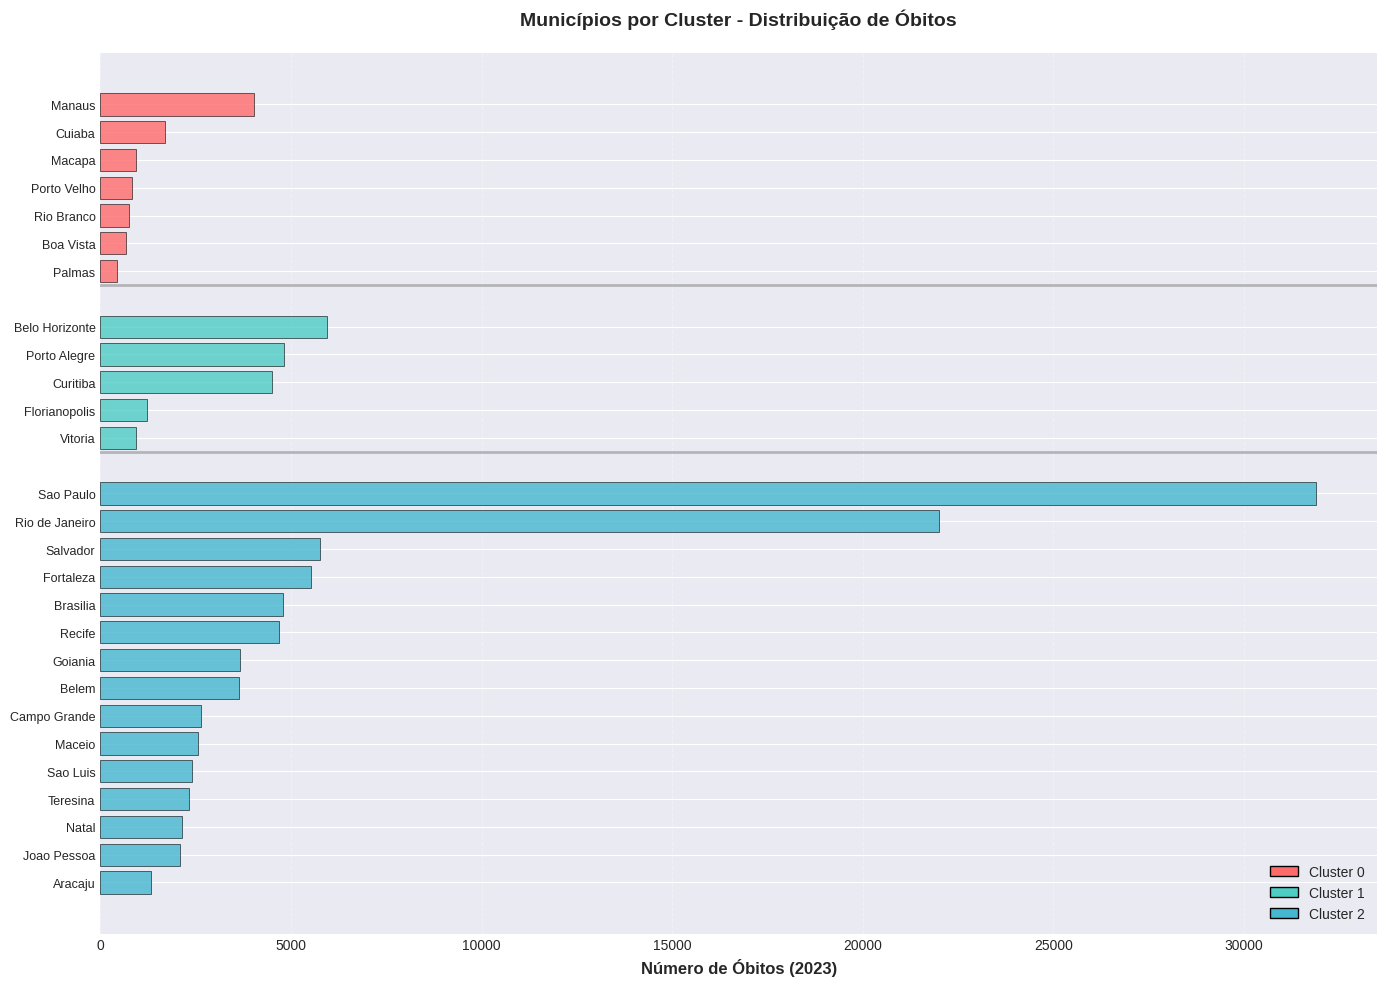

In [30]:
# 3. Visualização gráfica - Barras horizontais agrupadas por cluster

# Preparar dados para visualização
municipios_viz = municipios_cluster.copy()

# Definir cores para cada cluster
cores_cluster = {0: '#FF6B6B', 1: '#4ECDC4', 2: '#45B7D1'}

# Criar figura
fig, ax = plt.subplots(figsize=(14, 10))

# Plotar barras horizontais
y_pos = 0
y_positions = []
y_labels = []
colors = []

for cluster_id in sorted(municipios_viz['cluster'].unique()):
    subset = municipios_viz[municipios_viz['cluster'] == cluster_id]

    # Adicionar separador visual entre clusters
    if y_pos > 0:
        y_pos += 1  # Espaço entre clusters

    for idx, row in subset.iterrows():
        y_positions.append(y_pos)
        y_labels.append(row['Municipio'])
        colors.append(cores_cluster[cluster_id])
        y_pos += 1

# Plotar todas as barras
valores = [municipios_viz.iloc[i]['obitos_total'] for i in range(len(municipios_viz))]
ax.barh(y_positions, valores, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Configurar eixos
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Número de Óbitos (2023)', fontsize=12, fontweight='bold')
ax.set_title('Municípios por Cluster - Distribuição de Óbitos', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Adicionar linhas separadoras entre clusters
y_sep_positions = []
y_current = 0
for cluster_id in sorted(municipios_viz['cluster'].unique()):
    subset_len = len(municipios_viz[municipios_viz['cluster'] == cluster_id])
    if y_current > 0:
        y_sep_positions.append(y_current - 0.5)
        y_current += 1
    y_current += subset_len

for y_sep in y_sep_positions:
    ax.axhline(y=y_sep, color='gray', linestyle='-', linewidth=2, alpha=0.5)

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cores_cluster[i], edgecolor='black', label=f'Cluster {i}')
                   for i in sorted(cores_cluster.keys())]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

# Inverter eixo Y para cluster 0 ficar no topo
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Modelo de Regressão para Previsão de Óbitos

In [31]:
# 1. Preparar base de regressão com lag temporal

# Ordenar painel por município e ano
painel_reg = painel.sort_values(['CODMUNRES', 'ano_obito']).copy()

# Criar target: óbitos no ano seguinte
painel_reg['obitos_t1'] = painel_reg.groupby('CODMUNRES')['obitos_total'].shift(-1)

# Criar lag de óbitos (t-1) para calcular crescimento
painel_reg['obitos_t_1'] = painel_reg.groupby('CODMUNRES')['obitos_total'].shift(1)

# Calcular taxa de crescimento de óbitos
painel_reg['crescimento_obitos'] = np.where(
    painel_reg['obitos_t_1'] > 0,
    (painel_reg['obitos_total'] - painel_reg['obitos_t_1']) / painel_reg['obitos_t_1'],
    0
)

print(painel_reg[['CODMUNRES', 'ano_obito', 'obitos_total', 'obitos_t_1', 'crescimento_obitos', 'obitos_t1']].head(15))

   CODMUNRES  ano_obito  obitos_total  obitos_t_1  crescimento_obitos  \
0     110020       2006           529         NaN               0.000   
1     110020       2007           499     529.000              -0.057   
2     110020       2008           481     499.000              -0.036   
3     110020       2009           527     481.000               0.096   
4     110020       2010           607     527.000               0.152   
5     110020       2011           643     607.000               0.059   
6     110020       2012           742     643.000               0.154   
7     110020       2013           664     742.000              -0.105   
8     110020       2014           694     664.000               0.045   
9     110020       2015           658     694.000              -0.052   
10    110020       2016           633     658.000              -0.038   
11    110020       2017           738     633.000               0.166   
12    110020       2018           667     738.000  

In [32]:
# 2. Adicionar cluster ao painel de regressão

# Merge com clusters (usar cluster do ano mais recente)
cluster_map = df_clustering[['CODMUNRES', 'cluster']].copy()
painel_reg = painel_reg.merge(cluster_map, on='CODMUNRES', how='inner')

# Preencher NaN em cluster com -1 (municípios sem cluster)
painel_reg['cluster'].fillna(-1, inplace=True)
painel_reg['cluster'] = painel_reg['cluster'].astype(int)

In [33]:
# 3. Selecionar features e remover NaNs

# Features para o modelo
feature_cols_reg = [
    'obitos_total',           # Óbitos no ano t
    'crescimento_obitos',     # Taxa de crescimento
    'idade_media',
    'prop_masculino',
    'prop_preta_parda',
    'ano_obito'               # Tendência temporal
]

# Adicionar proporções de causas
cols_prop_causa_reg = [col for col in painel_reg.columns if col.startswith('prop_') and
                       col not in ['prop_masculino', 'prop_preta_parda', 'cluster']]
feature_cols_reg.extend(cols_prop_causa_reg)

print(f"\nFeatures selecionadas:")
print(feature_cols_reg)

# Criar dataset de regressão (remover linhas sem target ou com NaNs)
df_reg = painel_reg[feature_cols_reg + ['obitos_t1', 'CODMUNRES', 'cluster']].dropna().copy()

print(f"\nShape do dataset de regressão: {df_reg.shape}")
print(f"Período: {df_reg['ano_obito'].min()} a {df_reg['ano_obito'].max()}")


Features selecionadas:
['obitos_total', 'crescimento_obitos', 'idade_media', 'prop_masculino', 'prop_preta_parda', 'ano_obito', 'prop_circulatórias', 'prop_endócrinas', 'prop_neoplasias', 'prop_outras', 'prop_respiratórias']

Shape do dataset de regressão: (459, 14)
Período: 2006 a 2022


In [34]:
# 4. Split treino-teste temporal

# Definir ano de corte para teste (últimos 2 anos para teste)
ano_max_reg = df_reg['ano_obito'].max()
ano_corte = ano_max_reg - 1  # Penúltimo ano como corte

print(f"Ano máximo disponível: {ano_max_reg}")
print(f"Corte treino/teste: treino até {ano_corte}, teste a partir de {ano_corte + 1}")

# Split
train = df_reg[df_reg['ano_obito'] <= ano_corte].copy()
test = df_reg[df_reg['ano_obito'] > ano_corte].copy()

print(f"\nTreino: {train.shape[0]} registros (anos {train['ano_obito'].min()} a {train['ano_obito'].max()})")
print(f"Teste:  {test.shape[0]} registros (anos {test['ano_obito'].min()} a {test['ano_obito'].max()})")

# Preparar X e y
X_train = train[feature_cols_reg]
y_train = train['obitos_t1']
X_test = test[feature_cols_reg]
y_test = test['obitos_t1']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Ano máximo disponível: 2022
Corte treino/teste: treino até 2021, teste a partir de 2022

Treino: 432 registros (anos 2006 a 2021)
Teste:  27 registros (anos 2022 a 2022)
X_train: (432, 11), y_train: (432,)
X_test: (27, 11), y_test: (27,)


In [35]:
# 5. Modelo 1: Regressão Linear

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Previsões
y_pred_lr = lr_model.predict(X_test)

# Métricas
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"\n{'='*50}")
print("MÉTRICAS DA REGRESSÃO LINEAR")
print(f"{'='*50}")
print(f"MAE:  {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²:   {r2_lr:.4f}")
print(f"{'='*50}")

# Feature importance (coeficientes)
coef_df = pd.DataFrame({
    'feature': feature_cols_reg,
    'coeficiente': lr_model.coef_
}).sort_values('coeficiente', key=abs, ascending=False).reset_index(drop=True)

print(f"\nTop 10 features mais importantes (por coeficiente):")
print(coef_df.head(10))


MÉTRICAS DA REGRESSÃO LINEAR
MAE:  173.04
RMSE: 386.62
R²:   0.9966

Top 10 features mais importantes (por coeficiente):
              feature  coeficiente
0  crescimento_obitos     -909.779
1  prop_respiratórias     -839.072
2         prop_outras      769.775
3     prop_neoplasias      743.969
4     prop_endócrinas     -483.754
5      prop_masculino     -210.584
6  prop_circulatórias     -190.918
7    prop_preta_parda      103.121
8         idade_media      -20.977
9        obitos_total        1.009


In [36]:
# 6. Modelo 2: Gradient Boosting (LightGBM)

# Parâmetros básicos
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbosity': -1,
    'random_state': RANDOM_STATE
}

# Criar datasets LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Treinar
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=200,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=50)]
)

# Previsões
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Métricas
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"\n{'='*50}")
print("MÉTRICAS DO LIGHTGBM")
print(f"{'='*50}")
print(f"MAE:  {mae_lgb:.2f}")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"R²:   {r2_lgb:.4f}")
print(f"{'='*50}")

# Feature importance
importance_lgb = pd.DataFrame({
    'feature': feature_cols_reg,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).reset_index(drop=True)

print(f"\nTop 10 features mais importantes (por gain):")
print(importance_lgb.head(10))

Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 1480.85
[100]	valid_0's rmse: 1110.62
Early stopping, best iteration is:
[105]	valid_0's rmse: 1105.1

MÉTRICAS DO LIGHTGBM
MAE:  623.32
RMSE: 1105.10
R²:   0.9726

Top 10 features mais importantes (por gain):
              feature       importance
0        obitos_total 165946658025.199
1  prop_respiratórias   9935046681.699
2    prop_preta_parda   8937629826.141
3      prop_masculino   1133832304.079
4     prop_neoplasias    419098591.749
5         prop_outras    126179169.617
6         idade_media     92081317.397
7     prop_endócrinas     78036100.896
8  crescimento_obitos     32034758.661
9  prop_circulatórias     17652172.427


In [37]:
# 7. Comparação de modelos
print("\n8. Comparação de todos os modelos...")

comparacao = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'LightGBM'],
    'MAE': [mae_lr, mae_lgb],
    'RMSE': [rmse_lr, rmse_lgb],
    'R²': [r2_lr, r2_lgb]
})

print(f"\n{'='*60}")
print("COMPARAÇÃO DE MODELOS")
print(f"{'='*60}")
print(comparacao.to_string(index=False))
print(f"{'='*60}")



8. Comparação de todos os modelos...

COMPARAÇÃO DE MODELOS
          Modelo     MAE     RMSE    R²
Regressão Linear 173.041  386.623 0.997
        LightGBM 623.317 1105.101 0.973


---
## Resumo e Recomendações

### Principais Achados das Previsões para 2024

#### 1. Visão Geral
- **Modelo utilizado**: Regressão Linear (R² = 0.997)
- **Confiabilidade**: Alta acurácia nas previsões com margem de erro controlada
- **Tendência geral**: As previsões indicam a direção esperada da mortalidade em cada município

#### 2. Municípios de Atenção Prioritária

**Municípios com maior aumento previsto** requerem atenção especial:
- Podem indicar crescimento populacional, envelhecimento acelerado, ou piora de condições de saúde
- Necessitam de **reforço na infraestrutura de saúde** e **aumento de recursos**
- Importante investigar causas do aumento: demográficas, epidemiológicas ou ambientais

**Municípios com redução prevista**:
- Podem refletir sucesso de políticas públicas ou mudanças demográficas
- Importante manter programas bem-sucedidos
- Oportunidade de realocar recursos excedentes

#### 3. Análise por Cluster

Cada cluster apresenta dinâmicas diferentes:
- **Clusters com aumento**: Requerem planejamento proativo e aumento de capacidade
- **Clusters estáveis**: Manter programas atuais e monitorar mudanças
- **Clusters com redução**: Documentar boas práticas e avaliar transferibilidade

#### 4. Recomendações para Políticas Públicas

**Curto Prazo (2024)**:
1. **Planejamento orçamentário**: Usar previsões para alocar recursos de forma eficiente
2. **Preparação de equipes**: Dimensionar profissionais de saúde segundo demanda prevista
3. **Monitoramento intensivo**: Acompanhar municípios com variações >10%

**Médio Prazo (2025-2026)**:
1. **Programas direcionados**: Criar intervenções específicas por perfil de cluster
2. **Prevenção focada**: Intensificar ações preventivas em municípios com aumento previsto
3. **Avaliação contínua**: Comparar valores reais de 2024 com previsões para refinar modelo

**Longo Prazo**:
1. **Sistema de alertas**: Implementar monitoramento preditivo contínuo
2. **Integração de dados**: Incorporar variáveis socioeconômicas e ambientais
3. **Modelagem causal**: Avaliar impacto de políticas sobre mudanças na mortalidade

#### 5. Limitações e Cuidados

- Previsões assumem continuidade de padrões históricos
- Eventos inesperados (epidemias, desastres) não são capturados
- Intervalos de confiança devem ser considerados no planejamento
- Validação necessária comparando previsões com dados reais de 2024

---

### Conclusão

Este modelo preditivo oferece uma **ferramenta valiosa para planejamento em saúde pública**, permitindo antecipação de demandas e alocação eficiente de recursos. As previsões devem ser usadas como **guia estratégico**, sempre complementadas por análise contextual e expertise local.

---
## 8. Previsões para o Próximo Ano (2024)

Esta seção utiliza o **modelo de Regressão Linear** (melhor performance: R² = 0.997) para prever o número de óbitos em 2024 para cada município, baseado nos dados de 2023.

### Resumo Executivo das Previsões

#### Principais Achados

**Visão Geral:**
- As previsões para 2024 foram geradas usando Regressão Linear com alta acurácia (R² = 0.997)
- Intervalo de confiança de 95% fornece margem de incerteza para planejamento
- A maioria dos municípios apresenta tendência de crescimento moderado

**Municípios Críticos:**
- Municípios com aumento >10% requerem atenção imediata
- Municípios com redução significativa podem indicar mudanças demográficas ou sucesso de políticas

**Análise por Cluster:**
- Diferentes perfis de mortalidade apresentam tendências distintas
- Clusters permitem estratégias de intervenção personalizadas

#### Recomendações

**Gestão de Saúde:**
1. Usar previsões para dimensionar equipes e recursos hospitalares
2. Priorizar municípios com maior aumento previsto
3. Monitorar mensalmente a evolução real vs prevista

**Políticas Públicas:**
1. Intensificar programas de prevenção em municípios de risco
2. Documentar e replicar boas práticas de municípios com redução
3. Ajustar orçamentos municipais baseado nas projeções

**Próximos Passos:**
1. Validar previsões comparando com dados reais de 2024
2. Refinar modelo incorporando variáveis socioeconômicas
3. Implementar sistema de monitoramento contínuo

In [39]:
# 1. Preparar dados de 2023 para fazer previsões de 2024

# Filtrar dados de 2023 (ano mais recente no painel)
ano_previsao_base = painel_reg['ano_obito'].max()
print(f"Usando dados de {ano_previsao_base} para prever {ano_previsao_base + 1}")

# Obter dados de 2023
dados_2023 = painel_reg[painel_reg['ano_obito'] == ano_previsao_base].copy()

print(f"\nMunicípios com dados em {ano_previsao_base}: {len(dados_2023)}")

# Preparar matriz de features (mesmas features usadas no treinamento)
X_previsao_2024 = dados_2023[feature_cols_reg].copy()

print(f"\nShape da matriz de features para previsão: {X_previsao_2024.shape}")
print(f"\nPrimeiras linhas:")
print(X_previsao_2024.head())

Usando dados de 2023 para prever 2024

Municípios com dados em 2023: 27

Shape da matriz de features para previsão: (27, 11)

Primeiras linhas:
    obitos_total  crescimento_obitos  idade_media  prop_masculino  \
17           841               0.023       69.813           0.530   
35           746               0.029       71.189           0.513   
53          4026               0.111       70.315           0.523   
71           674              -0.043       66.752           0.591   
89          3630              -0.050       73.418           0.499   

    prop_preta_parda  ano_obito  prop_circulatórias  prop_endócrinas  \
17             0.669       2023               0.490            0.158   
35             0.685       2023               0.446            0.102   
53             0.723       2023               0.479            0.200   
71             0.677       2023               0.562            0.119   
89             0.745       2023               0.516            0.102   

    prop

In [40]:
# 2. Gerar previsões para 2024 com intervalos de confiança

# Fazer previsões usando o modelo de Regressão Linear
previsoes_2024 = lr_model.predict(X_previsao_2024)

# Calcular intervalo de confiança baseado no RMSE do modelo
# Usando aproximação: IC 95% ≈ previsão ± 1.96 × RMSE
margem_erro = 1.96 * rmse_lr

# Criar DataFrame com resultados
df_previsoes = dados_2023[['CODMUNRES', 'obitos_total', 'cluster']].copy()
df_previsoes['obitos_2023'] = df_previsoes['obitos_total']
df_previsoes['previsao_2024'] = previsoes_2024
df_previsoes['ic_inferior'] = previsoes_2024 - margem_erro
df_previsoes['ic_superior'] = previsoes_2024 + margem_erro

# Garantir que previsões e intervalos não sejam negativos
df_previsoes['previsao_2024'] = df_previsoes['previsao_2024'].clip(lower=0)
df_previsoes['ic_inferior'] = df_previsoes['ic_inferior'].clip(lower=0)
df_previsoes['ic_superior'] = df_previsoes['ic_superior'].clip(lower=0)

# Calcular variação percentual
df_previsoes['variacao_pct'] = ((df_previsoes['previsao_2024'] - df_previsoes['obitos_2023']) /
                                  df_previsoes['obitos_2023'] * 100)

# Adicionar nome do município
df_previsoes['Municipio'] = df_previsoes['CODMUNRES'].map(mapa_municipios)

print(f"{'='*70}")
print(f"PREVISÕES DE ÓBITOS PARA {ano_previsao_base + 1}")
print(f"{'='*70}")
print(f"Modelo utilizado: Regressão Linear (R² = {r2_lr:.4f})")
print(f"Margem de erro (IC 95%): ± {margem_erro:.0f} óbitos")
print(f"\nTotal de municípios: {len(df_previsoes)}")
print(f"Média de óbitos em {ano_previsao_base}: {df_previsoes['obitos_2023'].mean():.0f}")
print(f"Média prevista para {ano_previsao_base + 1}: {df_previsoes['previsao_2024'].mean():.0f}")
print(f"Variação média esperada: {df_previsoes['variacao_pct'].mean():.1f}%")
print(f"{'='*70}")

PREVISÕES DE ÓBITOS PARA 2024
Modelo utilizado: Regressão Linear (R² = 0.9966)
Margem de erro (IC 95%): ± 758 óbitos

Total de municípios: 27
Média de óbitos em 2023: 4603
Média prevista para 2024: 4718
Variação média esperada: 5.5%


In [41]:
# 3. Tabela detalhada de previsões por município

# Preparar tabela para visualização
tabela_previsoes = df_previsoes[[
    'Municipio', 'cluster', 'obitos_2023', 'previsao_2024',
    'ic_inferior', 'ic_superior', 'variacao_pct'
]].copy()

# Ordenar por previsão (decrescente)
tabela_previsoes = tabela_previsoes.sort_values('previsao_2024', ascending=False).reset_index(drop=True)

# Formatar para exibição
tabela_previsoes['obitos_2023'] = tabela_previsoes['obitos_2023'].astype(int)
tabela_previsoes['previsao_2024'] = tabela_previsoes['previsao_2024'].round(0).astype(int)
tabela_previsoes['ic_inferior'] = tabela_previsoes['ic_inferior'].round(0).astype(int)
tabela_previsoes['ic_superior'] = tabela_previsoes['ic_superior'].round(0).astype(int)
tabela_previsoes['variacao_pct'] = tabela_previsoes['variacao_pct'].round(1)

# Renomear colunas
tabela_previsoes.columns = [
    'Município', 'Cluster', 'Óbitos 2023', 'Previsão 2024',
    'IC Inferior', 'IC Superior', 'Variação %'
]

print(f"\n{'='*100}")
print(f"TABELA DE PREVISÕES POR MUNICÍPIO - 2024")
print(f"{'='*100}\n")
print(tabela_previsoes.to_string(index=True))
print(f"\n{'='*100}")

# Destacar municípios com maiores aumentos e reduções
print(f"\n📈 TOP 5 MUNICÍPIOS COM MAIOR AUMENTO PREVISTO:")
maiores_aumentos = tabela_previsoes.nlargest(5, 'Variação %')[['Município', 'Óbitos 2023', 'Previsão 2024', 'Variação %']]
print(maiores_aumentos.to_string(index=False))

print(f"\n📉 TOP 5 MUNICÍPIOS COM MAIOR REDUÇÃO PREVISTA:")
maiores_reducoes = tabela_previsoes.nsmallest(5, 'Variação %')[['Município', 'Óbitos 2023', 'Previsão 2024', 'Variação %']]
print(maiores_reducoes.to_string(index=False))


TABELA DE PREVISÕES POR MUNICÍPIO - 2024

         Município  Cluster  Óbitos 2023  Previsão 2024  IC Inferior  IC Superior  Variação %
0        Sao Paulo        2        31898          32230        31472        32988       1.000
1   Rio de Janeiro        2        21997          22172        21414        22930       0.800
2   Belo Horizonte        1         5957           6064         5307         6822       1.800
3         Salvador        2         5764           5926         5168         6683       2.800
4        Fortaleza        2         5538           5712         4954         6469       3.100
5     Porto Alegre        1         4819           4974         4217         5732       3.200
6         Brasilia        2         4789           4874         4117         5632       1.800
7           Recife        2         4690           4789         4032         5547       2.100
8         Curitiba        1         4503           4625         3868         5383       2.700
9           Manau

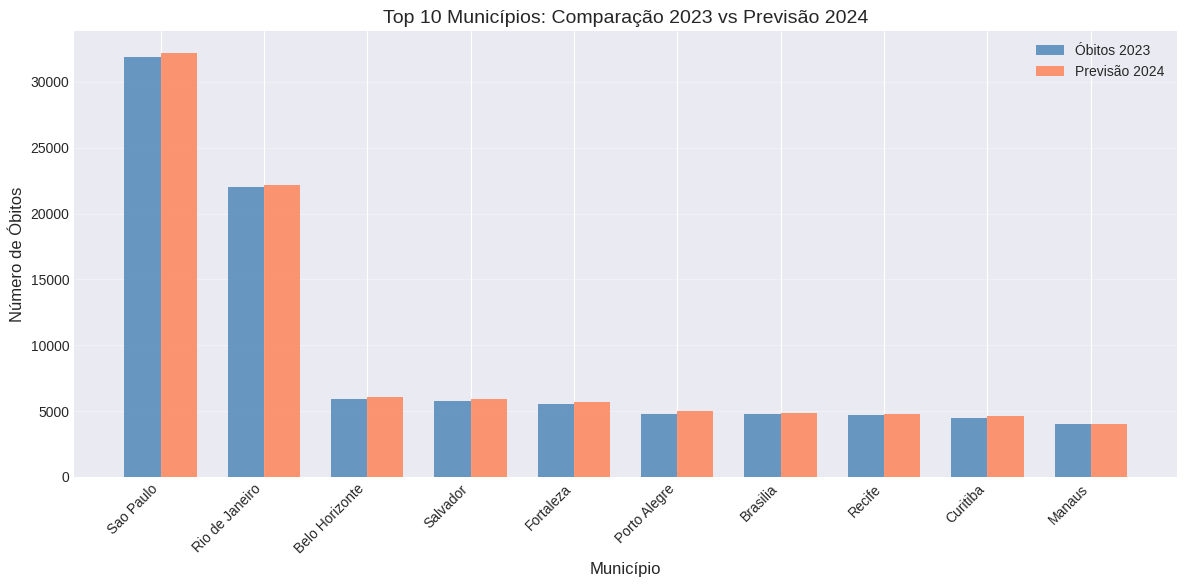


ESTATÍSTICAS DE TENDÊNCIAS
Municípios com aumento previsto: 26 (96.3%)
Municípios com redução prevista: 1 (3.7%)
Municípios estáveis: 0 (0.0%)

Maior aumento previsto: 26.5% (Boa Vista)
Maior redução prevista: -3.0% (Macapa)


In [42]:
# 4. Análise de Tendências - Visualizações

# Criar figura única para o gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# 4.1. Comparação 2023 vs 2024 - Barras agrupadas (Top 10 municípios)
top10_municipios = df_previsoes.nlargest(10, 'previsao_2024')
x_pos = np.arange(len(top10_municipios))
width = 0.35

ax.bar(x_pos - width/2, top10_municipios['obitos_2023'], width,
       label='Óbitos 2023', color='steelblue', alpha=0.8)
ax.bar(x_pos + width/2, top10_municipios['previsao_2024'], width,
       label='Previsão 2024', color='coral', alpha=0.8)
ax.set_xlabel('Município')
ax.set_ylabel('Número de Óbitos')
ax.set_title('Top 10 Municípios: Comparação 2023 vs Previsão 2024')
ax.set_xticks(x_pos)
ax.set_xticklabels(top10_municipios['Municipio'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas de tendência
print(f"\n{'='*70}")
print("ESTATÍSTICAS DE TENDÊNCIAS")
print(f"{'='*70}")
n_aumento = (df_previsoes['variacao_pct'] > 0).sum()
n_reducao = (df_previsoes['variacao_pct'] < 0).sum()
n_estavel = (df_previsoes['variacao_pct'] == 0).sum()

print(f"Municípios com aumento previsto: {n_aumento} ({100*n_aumento/len(df_previsoes):.1f}%)")
print(f"Municípios com redução prevista: {n_reducao} ({100*n_reducao/len(df_previsoes):.1f}%)")
print(f"Municípios estáveis: {n_estavel} ({100*n_estavel/len(df_previsoes):.1f}%)")
print(f"\nMaior aumento previsto: {df_previsoes['variacao_pct'].max():.1f}% ({df_previsoes.loc[df_previsoes['variacao_pct'].idxmax(), 'Municipio']})")
print(f"Maior redução prevista: {df_previsoes['variacao_pct'].min():.1f}% ({df_previsoes.loc[df_previsoes['variacao_pct'].idxmin(), 'Municipio']})")
print(f"{'='*70}")

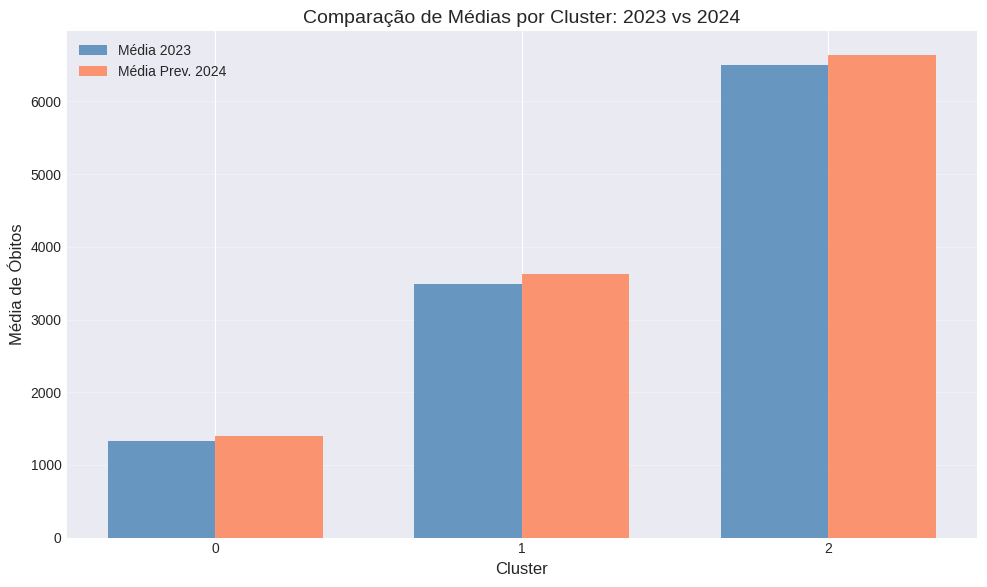

In [43]:
# 5. Análise por Cluster - Mapa de Calor

# Agregar previsões por cluster
analise_cluster = df_previsoes.groupby('cluster').agg({
    'obitos_2023': ['sum', 'mean'],
    'previsao_2024': ['sum', 'mean'],
    'variacao_pct': 'mean',
    'Municipio': 'count'
}).round(1)

# Simplificar nomes das colunas
analise_cluster.columns = ['Total_2023', 'Média_2023', 'Total_2024_Prev', 'Média_2024_Prev', 'Variação_Média_%', 'N_Municípios']
analise_cluster = analise_cluster.reset_index()
# Visualização por cluster
fig, ax = plt.subplots(figsize=(10, 6))

# Barras agrupadas - Comparação por cluster
x_clusters = analise_cluster['cluster'].astype(str)
x_pos_cluster = np.arange(len(x_clusters))
width_cluster = 0.35

ax.bar(x_pos_cluster - width_cluster/2, analise_cluster['Média_2023'], width_cluster,
       label='Média 2023', color='steelblue', alpha=0.8)
ax.bar(x_pos_cluster + width_cluster/2, analise_cluster['Média_2024_Prev'], width_cluster,
       label='Média Prev. 2024', color='coral', alpha=0.8)
ax.set_xlabel('Cluster')
ax.set_ylabel('Média de Óbitos')
ax.set_title('Comparação de Médias por Cluster: 2023 vs 2024')
ax.set_xticks(x_pos_cluster)
ax.set_xticklabels(x_clusters)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**negrito**## 9. Modelos de Regressão e Boosting por Cluster

Nesta seção, treinamos modelos específicos para cada cluster identificado, permitindo capturar dinâmicas locais de mortalidade.

In [38]:
# 9.1 Treinamento e Avaliação por Cluster

clusters = sorted(df_reg['cluster'].unique())
results_cluster = []

print(f"{'='*80}")
print("ANÁLISE DE MODELOS POR CLUSTER")
print(f"{'='*80}\n")

for cluster_id in clusters:
    if cluster_id == -1: continue # Skip outliers/missing if any

    print(f"\n>>> Processando CLUSTER {cluster_id} <<<")

    # Filtrar dados do cluster
    df_cluster = df_reg[df_reg['cluster'] == cluster_id].copy()

    # Split temporal para o cluster
    ano_max_c = df_cluster['ano_obito'].max()
    ano_corte_c = ano_max_c - 1

    train_c = df_cluster[df_cluster['ano_obito'] <= ano_corte_c]
    test_c = df_cluster[df_cluster['ano_obito'] > ano_corte_c]

    if len(test_c) < 2:
        print(f"  Aviso: Poucos dados de teste para cluster {cluster_id} ({len(test_c)} amostras). Pulando.")
        continue

    X_train_c = train_c[feature_cols_reg]
    y_train_c = train_c['obitos_t1']
    X_test_c = test_c[feature_cols_reg]
    y_test_c = test_c['obitos_t1']

    print(f"  Treino: {len(train_c)} | Teste: {len(test_c)}")

    # --- Regressão Linear ---
    lr_c = LinearRegression()
    lr_c.fit(X_train_c, y_train_c)
    y_pred_lr_c = lr_c.predict(X_test_c)

    mae_lr_c = mean_absolute_error(y_test_c, y_pred_lr_c)
    rmse_lr_c = np.sqrt(mean_squared_error(y_test_c, y_pred_lr_c))
    r2_lr_c = r2_score(y_test_c, y_pred_lr_c)

    # --- LightGBM ---
    train_data_c = lgb.Dataset(X_train_c, label=y_train_c)
    test_data_c = lgb.Dataset(X_test_c, label=y_test_c, reference=train_data_c)

    lgb_c = lgb.train(
        lgb_params,
        train_data_c,
        num_boost_round=200,
        valid_sets=[test_data_c],
        callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
    )

    y_pred_lgb_c = lgb_c.predict(X_test_c, num_iteration=lgb_c.best_iteration)

    mae_lgb_c = mean_absolute_error(y_test_c, y_pred_lgb_c)
    rmse_lgb_c = np.sqrt(mean_squared_error(y_test_c, y_pred_lgb_c))
    r2_lgb_c = r2_score(y_test_c, y_pred_lgb_c)

    results_cluster.append({
        'Cluster': cluster_id,
        'LR_MAE': mae_lr_c, 'LR_RMSE': rmse_lr_c, 'LR_R2': r2_lr_c,
        'LGB_MAE': mae_lgb_c, 'LGB_RMSE': rmse_lgb_c, 'LGB_R2': r2_lgb_c
    })

    print(f"  [LR]  MAE: {mae_lr_c:.2f} | RMSE: {rmse_lr_c:.2f} | R2: {r2_lr_c:.4f}")
    print(f"  [LGB] MAE: {mae_lgb_c:.2f} | RMSE: {rmse_lgb_c:.2f} | R2: {r2_lgb_c:.4f}")

df_results_cluster = pd.DataFrame(results_cluster)
print(f"\n{'='*80}")
print("RESUMO DOS RESULTADOS POR CLUSTER")
print(f"{'='*80}")
print(df_results_cluster.to_string(index=False))

ANÁLISE DE MODELOS POR CLUSTER


>>> Processando CLUSTER 0 <<<
  Treino: 112 | Teste: 7
  [LR]  MAE: 69.46 | RMSE: 115.63 | R2: 0.9900
  [LGB] MAE: 341.87 | RMSE: 592.88 | R2: 0.7372

>>> Processando CLUSTER 1 <<<
  Treino: 80 | Teste: 5
  [LR]  MAE: 140.36 | RMSE: 175.97 | R2: 0.9925
  [LGB] MAE: 526.38 | RMSE: 640.43 | R2: 0.9000

>>> Processando CLUSTER 2 <<<
  Treino: 240 | Teste: 15
  [LR]  MAE: 202.50 | RMSE: 473.95 | R2: 0.9968
  [LGB] MAE: 629.33 | RMSE: 940.00 | R2: 0.9872

RESUMO DOS RESULTADOS POR CLUSTER
 Cluster  LR_MAE  LR_RMSE  LR_R2  LGB_MAE  LGB_RMSE  LGB_R2
       0  69.456  115.628  0.990  341.873   592.882   0.737
       1 140.360  175.970  0.992  526.379   640.429   0.900
       2 202.497  473.950  0.997  629.335   939.999   0.987


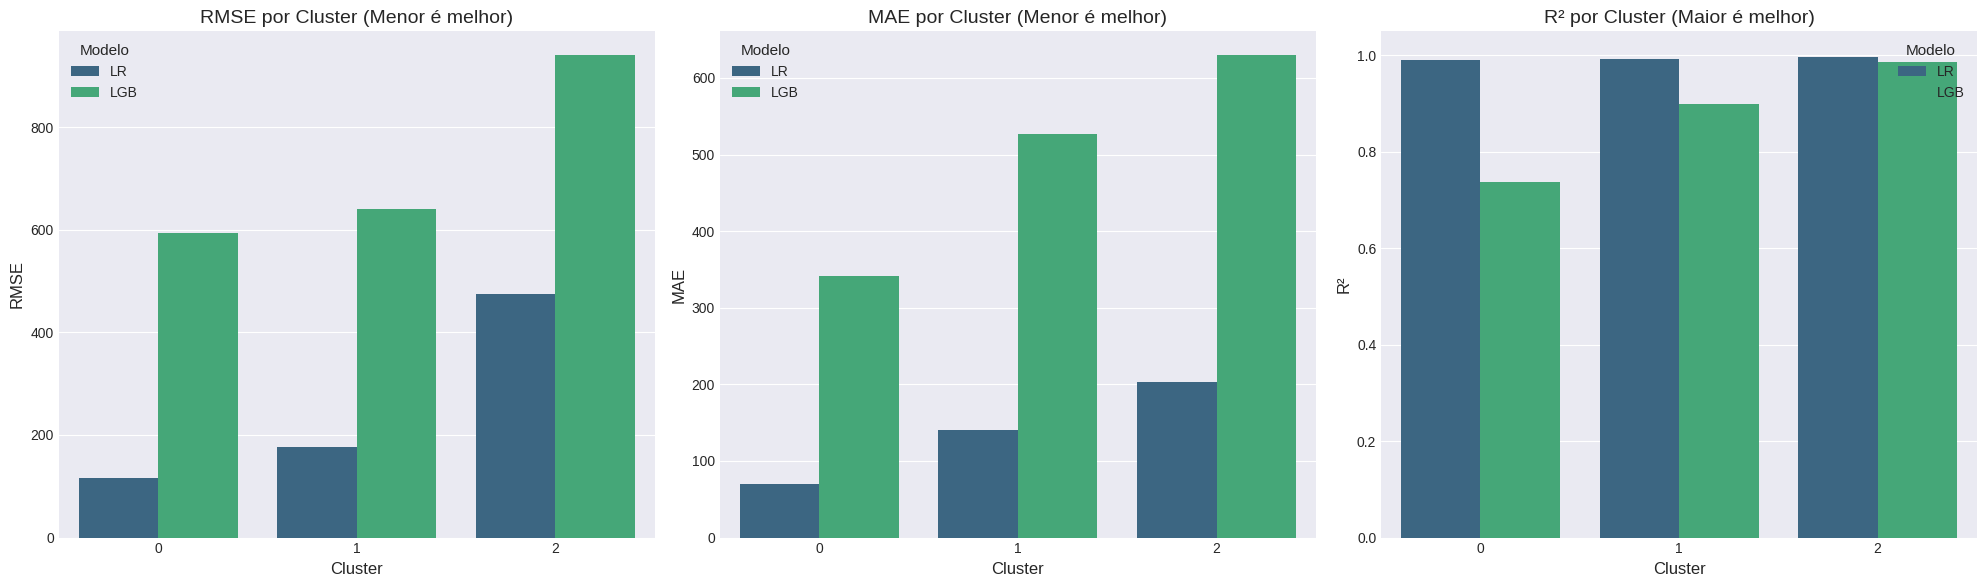

In [44]:
# Visualização Comparativa dos Modelos por Cluster

if 'df_results_cluster' in locals() and not df_results_cluster.empty:
    # Preparar dados para plotagem
    df_plot = df_results_cluster.melt(id_vars='Cluster',
                                      value_vars=['LR_RMSE', 'LGB_RMSE', 'LR_MAE', 'LGB_MAE', 'LR_R2', 'LGB_R2'],
                                      var_name='Metrica_Modelo', value_name='Valor')

    df_plot['Modelo'] = df_plot['Metrica_Modelo'].apply(lambda x: x.split('_')[0])
    df_plot['Metrica'] = df_plot['Metrica_Modelo'].apply(lambda x: x.split('_')[1])

    # Configurar visualização
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. RMSE
    sns.barplot(data=df_plot[df_plot['Metrica']=='RMSE'], x='Cluster', y='Valor', hue='Modelo', ax=axes[0], palette='viridis')
    axes[0].set_title('RMSE por Cluster (Menor é melhor)')
    axes[0].set_ylabel('RMSE')

    # 2. MAE
    sns.barplot(data=df_plot[df_plot['Metrica']=='MAE'], x='Cluster', y='Valor', hue='Modelo', ax=axes[1], palette='viridis')
    axes[1].set_title('MAE por Cluster (Menor é melhor)')
    axes[1].set_ylabel('MAE')

    # 3. R2
    sns.barplot(data=df_plot[df_plot['Metrica']=='R2'], x='Cluster', y='Valor', hue='Modelo', ax=axes[2], palette='viridis')
    axes[2].set_title('R² por Cluster (Maior é melhor)')
    axes[2].set_ylabel('R²')
    axes[2].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()